## Tarea Práctica 1: Gradient descent con TensorFlow
#### Statistical Learning I
##### Ruben Gonzalez 20003314

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
data = np.load("proyecto_training_data.npy")

In [3]:
import pandas as pd

In [4]:
pandas_dataframe = pd.DataFrame(data,columns=['SalePrice','OverallQual','1stFlrSF','TotRmsAbvGrd','YearBuilt','LotFrontage'])

In [5]:
pandas_dataframe.describe()

,SalePrice,OverallQual,1stFlrSF,TotRmsAbvGrd,YearBuilt,LotFrontage
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1201.000000
mean,180921.195890,6.099315,1162.626712,6.517808,1971.267808,70.049958
std,79442.502883,1.382997,386.587738,1.625393,30.202904,24.284752
min,34900.000000,1.000000,334.000000,2.000000,1872.000000,21.000000
25%,129975.000000,5.000000,882.000000,5.000000,1954.000000,59.000000
50%,163000.000000,6.000000,1087.000000,6.000000,1973.000000,69.000000
75%,214000.000000,7.000000,1391.250000,7.000000,2000.000000,80.000000
max,755000.000000,10.000000,4692.000000,14.000000,2010.000000,313.000000


In [6]:
pandas_dataframe.corr()

,SalePrice,OverallQual,1stFlrSF,TotRmsAbvGrd,YearBuilt,LotFrontage
SalePrice,1.000000,0.790982,0.605852,0.533723,0.522897,0.351799
OverallQual,0.790982,1.000000,0.476224,0.427452,0.572323,0.251646
1stFlrSF,0.605852,0.476224,1.000000,0.409516,0.281986,0.457181
TotRmsAbvGrd,0.533723,0.427452,0.409516,1.000000,0.095589,0.352096
YearBuilt,0.522897,0.572323,0.281986,0.095589,1.000000,0.123349
LotFrontage,0.351799,0.251646,0.457181,0.352096,0.123349,1.000000


In [7]:
import tensorflow.compat.v1 as tf
if tf.__version__.startswith("2."):
    import tensorflow.compat.v1 as tf
    tf.compat.v1.disable_v2_behavior()
    tf.compat.v1.disable_eager_execution()
    print("Enabled compatitility to tf1.x")

Instructions for updating:
non-resource variables are not supported in the long term
Enabled compatitility to tf1.x


#### Feature engineering a la data:
Creamos la matriz con columna de unos y los valores de x para el producto punto de la hipotesis junto con el arreglo de y

In [8]:
def matrizPreTensorflow(x,y):
    unos=np.ones(x.size)
    matrizx=pd.DataFrame()
    matrizx['x']=pd.Series(x)
    matrizx['unos']=pd.Series(unos)
    xfinal=np.array(matrizx)
    yfinal=np.array(y)
    return xfinal, yfinal

In [9]:
xparaTF,yparaTF=matrizPreTensorflow(pandas_dataframe['OverallQual'],pandas_dataframe['SalePrice'] )

Usando los datos obtenidos, los aplicaremos como entradas a nuestro grafo

In [16]:
class ModeloLineal:
    def __init__(self):
        self.parametros=tf.Variable([1., 1.])

    def __call__(self,x):
        return tf.tensordot(x,self.parametros,1)

    def actualizar(self,x,y,lr):
        #Calculo de yhat
        yhat = self(x)

        #Calculo del error
        with tf.name_scope("Error"):
            derror=tf.reduce_mean(tf.math.square(y-yhat))*0.5
            derror_summary = tf.summary.scalar("ErrorSummary", derror)
        
        #Calculo de gradientes
        with tf.name_scope("Gradiente"):
            gradiente = tf.gradients(derror,self.parametros)

        #Actualizar mb
        with tf.name_scope("Parametros"):
            lrgrad=tf.math.multiply(gradiente,lr)
            nuevaAsig=tf.math.subtract(self.parametros,lrgrad)
            retorna=tf.assign(self.parametros, nuevaAsig[0])

        return derror_summary, derror, retorna

In [30]:
#------------Inicio del grafo
def AplicarModeloLineal(matrizX,vectorY,learning_rate,epochs,imprimir_error_cada):
    g=tf.Graph()
    with g.as_default():
        modelo = ModeloLineal()
        tensor_x=tf.placeholder(tf.float32,[1460,2],"tensor_x")
        tensor_y=tf.placeholder(tf.float32,[1460],"tensor_y")
        lr=tf.placeholder(tf.float32,[],"lr")

        prediccion = modelo(tensor_x)
        actualizacion_parametros = modelo.actualizar(tensor_x,tensor_y,lr)
    #------------Fin del grafo
        nombreArchivo = './gradiente/Model' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '_lr=' + str(learning_rate) + '_epochs=' + str(epochs)
        writer = tf.summary.FileWriter(nombreArchivo, g)

        with tf.train.MonitoredSession() as session:
            feed_dict = {tensor_x:matrizX, tensor_y:vectorY, lr:learning_rate}

            for i in range(epochs):
                salida=session.run(actualizacion_parametros,feed_dict=feed_dict)
                predicciones = session.run(prediccion,feed_dict=feed_dict)
                writer.add_summary(salida[0],i)
                if (i % imprimir_error_cada == 0 and i!=0):
                    print("Epoch: ",i," Error: ",salida[1]," Parametros: ",salida[2])
            writer.close()

### Hipotesis:
La funcion de hipotesis a utilizar sera un modelo lineal de tipo Y=mx+b donde en nuestro modelo buscaremos calcular los parametros m y b optimos para modelar de la mejor forma el comportamiento dados los valores proporcionados por el dataset. Como hiper parametros de la funcion utilizamos el learning-rate y la cantidad de iteraciones que realizara el algoritmo hasta llegar a un resultado final.


Aplicando la funcion a 10 modelos distintos variando epochs y learning rate:

In [44]:
AplicarModeloLineal(xparaTF,yparaTF,0.00018,7000,500)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  500  Error:  1439826800.0  Parametros:  [28968.426   4080.2605]
Epoch:  1000  Error:  1424727300.0  Parametros:  [29804.678   3770.1453]
Epoch:  1500  Error:  1422629000.0  Parametros:  [29892.184  3345.019]
Epoch:  2000  Error:  1420558800.0  Parametros:  [29959.22    2918.6084]
Epoch:  2500  Error:  1418506100.0  Parametros:  [30025.627   2493.9685]
Epoch:  3000  Error:  1416470900.0  Parametros:  [30091.654  2071.089]
Epoch:  3500  Error:  1414452500.0  Parametros:  [30157.312   1650.0598]
Epoch:  4000  Error:  1412452400.0  Parametros:  [30222.754   1230.8673]
Epoch:  4500  Error:  1410469000.0  Parametros:  [30288.055    813.4163]
Epoch:  5000  Error:  1408502000.0  Parametros:  [30352.875     397.75394]
Epoch:  5500  Error:  1406553000.0  Parametros:  [ 3.0417418e+04 -1.6085299e+01]
Epoch:  6000  Error:  1404620000.0  Parametros:  [30481.871    -428.1536

In [32]:
AplicarModeloLineal(xparaTF,yparaTF,0.0008,7000,500)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  500  Error:  1419643900.0  Parametros:  [29989.295   2726.6572]
Epoch:  1000  Error:  1410687500.0  Parametros:  [30281.26      856.65875]
Epoch:  1500  Error:  1402067000.0  Parametros:  [30567.725   -977.9922]
Epoch:  2000  Error:  1393768700.0  Parametros:  [30848.736  -2777.9646]
Epoch:  2500  Error:  1385781600.0  Parametros:  [31124.467 -4543.912]
Epoch:  3000  Error:  1378093600.0  Parametros:  [31394.975 -6276.48 ]
Epoch:  3500  Error:  1370693000.0  Parametros:  [31660.361 -7976.3  ]
Epoch:  4000  Error:  1363569800.0  Parametros:  [31920.736 -9643.987]
Epoch:  4500  Error:  1356713500.0  Parametros:  [ 32176.193 -11280.153]
Epoch:  5000  Error:  1350113800.0  Parametros:  [ 32426.824 -12885.394]
Epoch:  5500  Error:  1343761400.0  Parametros:  [ 32672.727 -14460.297]
Epoch:  6000  Error:  1337646500.0  Parametros:  [ 32913.957 -16005.417]
Epoch:  650

In [33]:
AplicarModeloLineal(xparaTF,yparaTF,0.003,5000,500)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  500  Error:  1395811700.0  Parametros:  [30780.602  -2341.4622]
Epoch:  1000  Error:  1367093800.0  Parametros:  [31792.748 -8824.115]
Epoch:  1500  Error:  1342205800.0  Parametros:  [ 32734.988 -14859.049]
Epoch:  2000  Error:  1320636800.0  Parametros:  [ 33612.145 -20477.156]
Epoch:  2500  Error:  1301944000.0  Parametros:  [ 34428.73  -25707.258]
Epoch:  3000  Error:  1285744400.0  Parametros:  [ 35188.918 -30576.15 ]
Epoch:  3500  Error:  1271705100.0  Parametros:  [ 35896.6  -35108.76]
Epoch:  4000  Error:  1259538000.0  Parametros:  [ 36555.41 -39328.34]
Epoch:  4500  Error:  1248993400.0  Parametros:  [ 37168.71 -43256.49]


In [34]:
AplicarModeloLineal(xparaTF,yparaTF,0.003,9000,700)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  700  Error:  1383829500.0  Parametros:  [31194.172  -4990.3203]
Epoch:  1400  Error:  1346902700.0  Parametros:  [ 32551.895 -13686.365]
Epoch:  2100  Error:  1316681500.0  Parametros:  [ 33780.168 -21553.33 ]
Epoch:  2800  Error:  1291947600.0  Parametros:  [ 34891.355 -28670.3  ]
Epoch:  3500  Error:  1271705100.0  Parametros:  [ 35896.6  -35108.76]
Epoch:  4200  Error:  1255137800.0  Parametros:  [ 36806.008 -40933.42 ]
Epoch:  4900  Error:  1241579500.0  Parametros:  [ 37628.715 -46202.77 ]
Epoch:  5600  Error:  1230483200.0  Parametros:  [ 38372.996 -50969.777]
Epoch:  6300  Error:  1221401100.0  Parametros:  [ 39046.312 -55282.312]
Epoch:  7000  Error:  1213968500.0  Parametros:  [ 39655.445 -59183.71 ]
Epoch:  7700  Error:  1207884800.0  Parametros:  [ 40206.516 -62713.184]
Epoch:  8400  Error:  1202906600.0  Parametros:  [ 40705.035 -65906.16 ]


In [35]:
AplicarModeloLineal(xparaTF,yparaTF,0.0003,9000,700)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  700  Error:  1424020100.0  Parametros:  [29842.111  3628.916]
Epoch:  1400  Error:  1419188500.0  Parametros:  [30003.605   2634.6943]
Epoch:  2100  Error:  1414452900.0  Parametros:  [30157.43    1649.4574]
Epoch:  2800  Error:  1409811200.0  Parametros:  [30309.738    674.0403]
Epoch:  3500  Error:  1405261800.0  Parametros:  [30460.543   -291.6567]
Epoch:  4200  Error:  1400802600.0  Parametros:  [30609.852  -1247.7302]
Epoch:  4900  Error:  1396431900.0  Parametros:  [30757.63  -2194.275]
Epoch:  5600  Error:  1392148200.0  Parametros:  [30903.932  -3131.3828]
Epoch:  6300  Error:  1387949400.0  Parametros:  [31048.775  -4059.1492]
Epoch:  7000  Error:  1383833600.0  Parametros:  [31192.176  -4977.6665]
Epoch:  7700  Error:  1379799300.0  Parametros:  [31334.15   -5887.0273]
Epoch:  8400  Error:  1375845400.0  Parametros:  [31474.709  -6787.3223]


In [36]:
AplicarModeloLineal(xparaTF,yparaTF,0.00015,10000,800)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  800  Error:  1427291300.0  Parametros:  [29543.596   4023.1067]
Epoch:  1600  Error:  1423323400.0  Parametros:  [29868.553  3487.527]
Epoch:  2400  Error:  1420558300.0  Parametros:  [29959.3     2918.7444]
Epoch:  3200  Error:  1417825900.0  Parametros:  [30047.629   2352.8926]
Epoch:  4000  Error:  1415123700.0  Parametros:  [30135.355   1790.3431]
Epoch:  4800  Error:  1412452700.0  Parametros:  [30222.855   1231.0101]
Epoch:  5600  Error:  1409811500.0  Parametros:  [30309.648    674.7805]
Epoch:  6400  Error:  1407201400.0  Parametros:  [30395.88       121.800644]
Epoch:  7200  Error:  1404620000.0  Parametros:  [30481.82     -427.99298]
Epoch:  8000  Error:  1402068000.0  Parametros:  [30567.21    -974.7549]
Epoch:  8800  Error:  1399546100.0  Parametros:  [30651.977  -1518.3326]
Epoch:  9600  Error:  1397052300.0  Parametros:  [30736.373  -2058.7532]


In [37]:
AplicarModeloLineal(xparaTF,yparaTF,0.0014,10000,1000)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  1000  Error:  1397877600.0  Parametros:  [30709.35   -1885.1035]
Epoch:  2000  Error:  1370691700.0  Parametros:  [31660.807 -7979.095]
Epoch:  3000  Error:  1346905200.0  Parametros:  [ 32550.799 -13679.351]
Epoch:  4000  Error:  1326093400.0  Parametros:  [ 33383.258 -19011.264]
Epoch:  5000  Error:  1307884300.0  Parametros:  [ 34161.953 -23998.658]
Epoch:  6000  Error:  1291951700.0  Parametros:  [ 34890.336 -28663.838]
Epoch:  7000  Error:  1278011400.0  Parametros:  [ 35571.664 -33027.598]
Epoch:  8000  Error:  1265814800.0  Parametros:  [ 36208.95  -37109.402]
Epoch:  9000  Error:  1255142500.0  Parametros:  [ 36805.094 -40927.49 ]


In [38]:
AplicarModeloLineal(xparaTF,yparaTF,0.0004,9000,500)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  500  Error:  1424253700.0  Parametros:  [29831.857  3675.633]
Epoch:  1000  Error:  1419643600.0  Parametros:  [29988.967   2728.5688]
Epoch:  1500  Error:  1415123700.0  Parametros:  [30135.69    1789.1145]
Epoch:  2000  Error:  1410688000.0  Parametros:  [30280.93     858.5842]
Epoch:  2500  Error:  1406336900.0  Parametros:  [30424.873     -63.10621]
Epoch:  3000  Error:  1402067300.0  Parametros:  [30567.393   -976.0549]
Epoch:  3500  Error:  1397878800.0  Parametros:  [30708.562  -1880.3218]
Epoch:  4000  Error:  1393769900.0  Parametros:  [30848.453  -2776.0107]
Epoch:  4500  Error:  1389738200.0  Parametros:  [30986.926  -3663.1926]
Epoch:  5000  Error:  1385782700.0  Parametros:  [31124.129 -4541.941]
Epoch:  5500  Error:  1381901800.0  Parametros:  [31260.066  -5412.3564]
Epoch:  6000  Error:  1378095000.0  Parametros:  [31394.637  -6274.5044]
Epoch: 

In [39]:
AplicarModeloLineal(xparaTF,yparaTF,0.00012,8000,800)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  800  Error:  1434783600.0  Parametros:  [29137.867   4077.5718]
Epoch:  1600  Error:  1424441600.0  Parametros:  [29821.53    3714.4568]
Epoch:  2400  Error:  1422214100.0  Parametros:  [29905.73    3259.8943]
Epoch:  3200  Error:  1420009600.0  Parametros:  [29976.932   2805.4556]
Epoch:  4000  Error:  1417826300.0  Parametros:  [30047.47    2353.1082]
Epoch:  4800  Error:  1415662100.0  Parametros:  [30117.79  1902.86]
Epoch:  5600  Error:  1413518000.0  Parametros:  [30188.002   1454.5746]
Epoch:  6400  Error:  1411392600.0  Parametros:  [30257.596   1008.3076]
Epoch:  7200  Error:  1409287400.0  Parametros:  [30326.861     564.12787]


In [40]:
AplicarModeloLineal(xparaTF,yparaTF,0.00007,10000,800)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  800  Error:  1629866000.0  Parametros:  [26602.66    3878.3977]
Epoch:  1600  Error:  1428568800.0  Parametros:  [29444.057   4047.1616]
Epoch:  2400  Error:  1425022700.0  Parametros:  [29781.86    3825.7625]
Epoch:  3200  Error:  1423695000.0  Parametros:  [29854.814  3563.748]
Epoch:  4000  Error:  1422398300.0  Parametros:  [29899.607  3298.07 ]
Epoch:  4800  Error:  1421109400.0  Parametros:  [29941.531   3032.6448]
Epoch:  5600  Error:  1419826600.0  Parametros:  [29982.818  2767.889]
Epoch:  6400  Error:  1418551400.0  Parametros:  [30023.99    2503.8567]
Epoch:  7200  Error:  1417282800.0  Parametros:  [30065.053   2240.5408]
Epoch:  8000  Error:  1416021100.0  Parametros:  [30106.002   1977.9464]
Epoch:  8800  Error:  1414766300.0  Parametros:  [30146.84    1716.0709]
Epoch:  9600  Error:  1413517800.0  Parametros:  [30187.566   1454.9097]


In [12]:
%load_ext tensorboard

In [14]:
%tensorboard --logdir ./gradiente

Reusing TensorBoard on port 6006 (pid 15592), started 0:01:02 ago. (Use '!kill 15592' to kill it.)

## Grafo generado

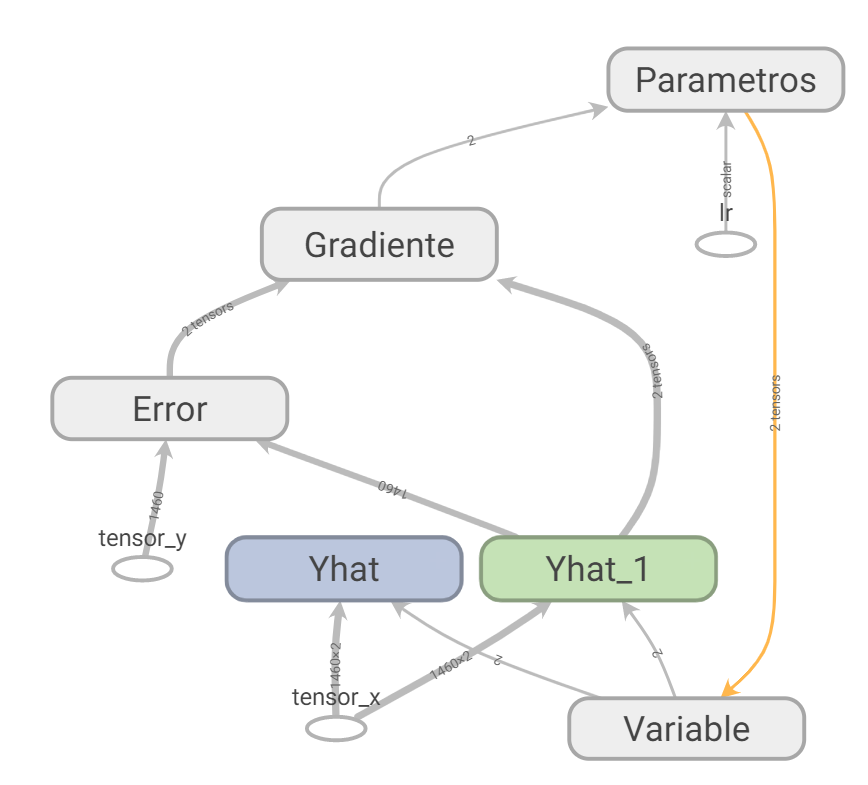

### Experimentos realizados:
A continuacion se muestran los resultados graficos de los experimentos realizados arriba

<img src='Error_ErrorSummary.svg'>

<img src='Error_ErrorSummary2.svg'>

### Conclusion:
El grafico que llega antes a la convergencia es el naranja por lo tanto es el mejor modelo de prediccion. Este modelo utilizo el learning rate de 0.0003 y un epoch de 9000.